## The Notebook for Power Dependence Analysis of Photodissociation Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import odr
from processing import ProcessData
from constants import ApproachEnum, MeasureEnum, lifetime_outfile, plot_params, confidence
from pathlib import Path
from scipy.stats import gaussian_kde
%matplotlib inline

### Process power dependence data

In [2]:
task = 'run_9'
process = ProcessData(task, copy_files=False, do_2photon=False, process_y_line_sum=False)

In [3]:
process.run(do_int=True, do_liv=True, plot=True, save_plot=True)

In [4]:
df = pd.read_csv(lifetime_outfile(task, MeasureEnum.live, ApproachEnum.bayesian), sep="    ", engine="python")
df

,wl(nm),mean_lt(s),mle_lt(s),CI_low[lt],CI_high[lt],int(W/m2),int_er,label,file
0,250,34.302000,30.3,25.5,42.6,183.001612,15.994426,250 p6 1 230221,2023_02_21_10h_39m_46s_dissociation_measurement
1,250,128.178824,114.6,98.1,157.8,109.975148,9.317116,250 p4 1 230228,2023_02_28_11h_10m_39s_dissociation_measurement
2,250,58.051667,49.8,41.7,73.8,281.879276,23.254908,250 p10 1 230301,2023_03_01_10h_13m_12s_dissociation_measurement
3,250,21.373529,19.2,16.2,26.4,288.626565,24.086162,250 p10 1 230302,2023_03_02_10h_45m_42s_dissociation_measurement


### Plot power dependence

In [5]:
x = df["int(W/m2)"].values
dx = df["int_er"].values
y = 1 / df["mle_lt(s)"].values
y_max = 1 / df["CI_low[lt]"].values
y_min = 1 / df["CI_high[lt]"].values
dy = np.array([y - y_min, y_max - y])

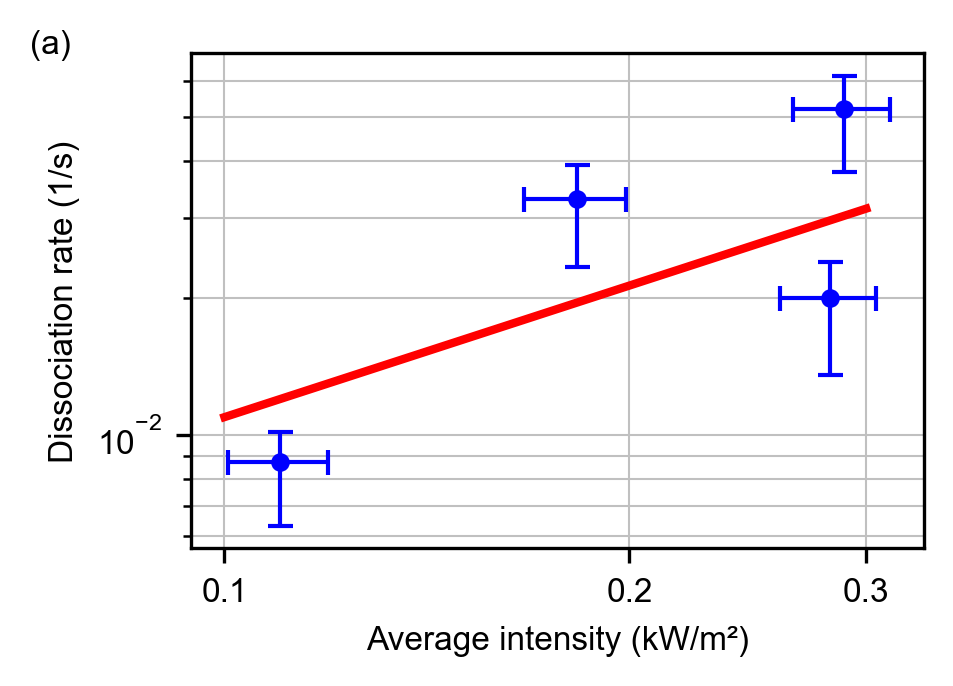

In [6]:
plt.rcParams.update(plot_params)
fig, ax = plt.subplots()
fit_x = np.linspace(0.1, 0.3, 100)
fit_y = 0.1 * fit_x**0.95  # taken from the fit mentioned below
ax.plot(fit_x, fit_y, color=(1,0,0,1), linewidth=2.0)
# ax.fill_between(fit_x, fit_y_min, fit_y_max, facecolor=(1,0,0,.2), edgecolor=(1,0,0,.01))
ax.scatter(x*1e-3, y, marker="o", c="b", s=12, zorder=10)
ax.errorbar(x*1e-3, y, xerr=dx*1e-3, yerr=dy, fmt="", ls="none", ecolor="b", elinewidth=1.0, capsize=3.0, capthick=1.0, zorder=10)
ax.set_xlabel(r"Average intensity (kW/m²)")
ax.set_ylabel(r"Dissociation rate (1/s)")
ax.grid(True, which="both")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks(np.arange(0.1,0.35,0.1))
ax.set_xticklabels([0.1,0.2,0.3])
# ax.set_yticks(np.arange(0.01,0.05,0.01))
# ax.set_yticklabels([0.01,0.02,0.03,0.04])
ax.text(-0.22, 1.0, "(a)", transform=plt.gca().transAxes)
plt.savefig('power_dependence_1photon.eps', format='eps', dpi=300)

### Fitting functions

In [7]:
def exp_func(beta, x):
    return beta[0] * x**beta[1]

def linear_func(beta, x):
    return beta * x

### Read in Monte Carlo samples

In [8]:
def samples_file_intensity(measurement):
    return Path().cwd().joinpath(f'samples/samples_intensity/{measurement}_intensity.npy')
def samples_file_lifetime(measurement, meas_type:MeasureEnum):
    return Path().cwd().joinpath(f'samples/samples_lifetime/{measurement}_lifetime_{meas_type.value}.npy')
def samples_array_intensity():
    samples_list = []
    for measurement in process.data.datainfo_json.keys():
        with open(samples_file_intensity(measurement), 'rb') as f:
            samples = np.load(f)
            samples_list.append(samples)
    return np.array(samples_list).T
def samples_array_lifetime(meas_type:MeasureEnum):
    samples_list = []
    for measurement in process.data.datainfo_json.keys():
        with open(samples_file_lifetime(measurement, meas_type), 'rb') as f:
            samples = np.load(f)
            samples_list.append(samples)
    return np.array(samples_list).T

In [9]:
samples_intensity = samples_array_intensity()
print(np.mean(samples_intensity, axis=0))
samples_lifetime = samples_array_lifetime(MeasureEnum.live)
print(np.mean(samples_lifetime, axis=0))

[183.00161157 109.97514791 281.87927646 288.62656538]
[ 34.306359 128.317206  58.135332  21.366222]


### Fitting each sample to power law

In [10]:
def exp_fit(x_array, y_array):
    data = odr.RealData(x_array, y_array)
    model = odr.Model(exp_func)
    o = odr.ODR(data, model, beta0=[0.2, 1.0])
    out = o.run()
    return out.beta

In [11]:
samples_fit = np.array([exp_fit(samples_intensity[i]*1e-3, 1/samples_lifetime[i]) for i in range(samples_intensity.shape[0])])

### KDE of the fits: coefficient

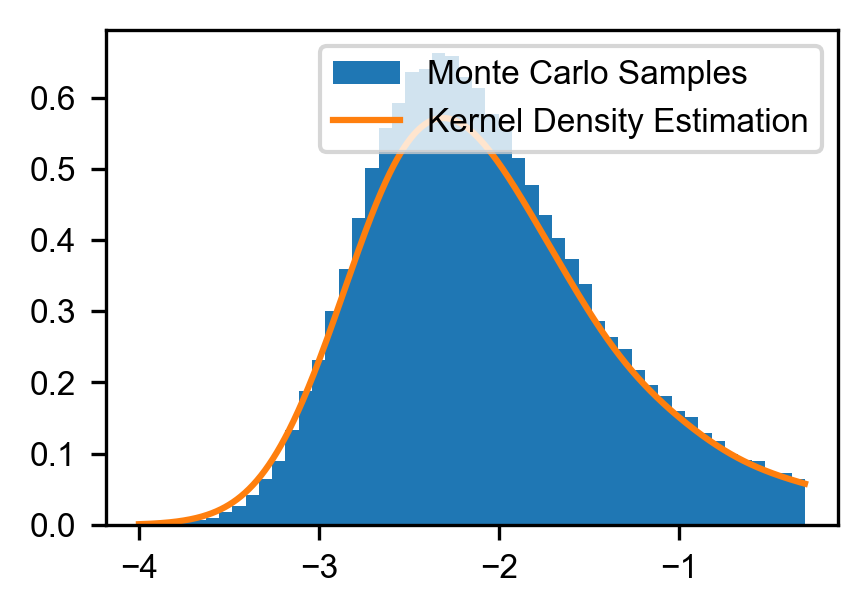

In [12]:
kde_0 = gaussian_kde(np.log(samples_fit.T[0]))
x_kde_0 = np.linspace(-4.0, -0.3, 1000)
y_kde_0 = kde_0(x_kde_0)
plt.hist(np.log(samples_fit.T[0]), bins=50, range=(-4.0, -0.3), density=True, label='Monte Carlo Samples')
plt.plot(x_kde_0, y_kde_0, label='Kernel Density Estimation')
plt.legend()

In [13]:
max_x_0 = x_kde_0[np.argmax(y_kde_0)]
np.e**max_x_0

0.09915102252982531

### KDE of the fits: exponent

In [14]:
# filter out invalid fits with exponent < 0.1 or > 10.0
data = samples_fit.T[1]
samples_filtered = data[(data > 0.1) & (data < 10.0)]
samples_filtered

array([0.7558501 , 1.06180066, 1.98455726, ..., 1.20222704, 1.52828653,
       1.91088945])

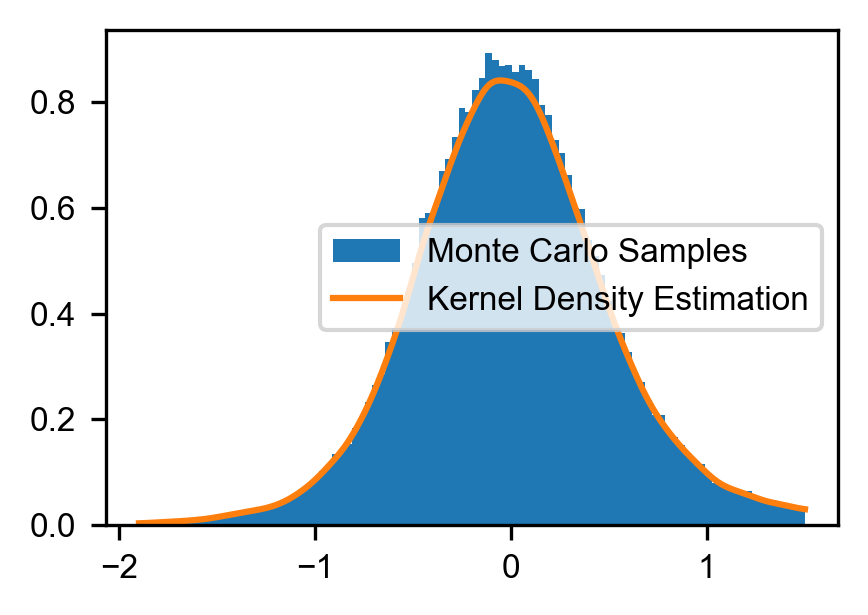

In [15]:
kde_1 = gaussian_kde(np.log(samples_filtered))
x_kde_1 = np.linspace(-1.9, 1.5, 1000)
y_kde_1 = kde_1(x_kde_1)
plt.hist(np.log(samples_filtered), bins=100, range=(-1.9, 1.5), density=True, label='Monte Carlo Samples')
plt.plot(x_kde_1, y_kde_1, label='Kernel Density Estimation')
plt.legend()

In [16]:
max_x_1 = x_kde_1[np.argmax(y_kde_1)]
np.e**max_x_1

0.9461488691401716

In [17]:
np.percentile(samples_filtered, (1+confidence)/2*100)

1.6857149653641816

In [18]:
np.percentile(samples_filtered, (1-confidence)/2*100)

0.6335132298596655